In [1]:
import numpy as np
import collections
import os

INFO_FIELDS = ['stat', 'causality']
class LocusResult(collections.namedtuple('_LocusResult', INFO_FIELDS)):
    __slots__ = ()

In [45]:
startsim = 701
endsim = 750
zmax = 3
muvar = '0'
nbin = 10

basedir = '/scratch/sbanerj/quasi_laplace_gwas'
blore_path = 'blore_cvar/meta_without_feature/zmax{:d}_mu{:s}_pi0.01_sig0.01/blore_meta_res/{:s}.res'
calib_outfile = 'calibration_pip_z{:d}.pdf'.format(zmax)

simrange = range(startsim, endsim + 1)

In [46]:
locusfile = os.path.join(basedir, 'LOCUSNAMES.50NLOCI')
with open(locusfile, 'r') as mfile:
    locusprefixes = mfile.readlines()
locusprefixes = [x.strip() for x in locusprefixes]

In [47]:
def read_causal_rsids(causal_snps_file):
    causal_rsid = dict()
    with open(causal_snps_file, 'r') as mfile:
        rsidlist = list()
        locus_name = ''
        for line in mfile:
            if line.startswith('#'):
                causal_rsid[locus_name] = rsidlist
            else:
                mline =  line.split()
                if mline[0].startswith('Causality'):
                    locus_name = mline[1]
                    rsidlist = list()
                else:
                    rsidlist.append(mline[0])
        causal_rsid[locus_name] = rsidlist
    return causal_rsid

def read_blore(simdir, filepath, locusprefixes, causal_rsids, zmax, muvar):
    thisres = list()
    for locus in locusprefixes:
        locusres = list()
        outfile = os.path.join(simdir, filepath.format(zmax, muvar, locus))
        causals = causal_rsids[locus]
        with open(outfile, 'r') as mfile:
            next(mfile)
            for mline in mfile:
                mline_split = mline.split()
                rsid = mline_split[0]
                prob = float(mline_split[4])
                causality = 1 if rsid in causals else 0
                mres = LocusResult(stat = prob,
                                   causality = causality)
                locusres.append(mres)
        thisres.append(locusres)
    return thisres

In [48]:
blore = list()

for sim in range(startsim, endsim + 1):
    simname = 'sim{:03d}'.format(sim)
    print ('Reading {:s}'.format(simname))
    simdir = os.path.join( basedir, 'simulations', simname)
    causal_snps_file = os.path.join(simdir, 'samples', 'causal.snplist')
    causal_rsids = read_causal_rsids(causal_snps_file)
    thisres = read_blore(simdir, blore_path, locusprefixes, causal_rsids, zmax, '0')
    blore.append(thisres)
    
blore = [x for y in blore for x in y]
blore = [x for y in blore for x in y]

Reading sim701
Reading sim702
Reading sim703
Reading sim704
Reading sim705
Reading sim706
Reading sim707
Reading sim708
Reading sim709
Reading sim710
Reading sim711
Reading sim712
Reading sim713
Reading sim714
Reading sim715
Reading sim716
Reading sim717
Reading sim718
Reading sim719
Reading sim720
Reading sim721
Reading sim722
Reading sim723
Reading sim724
Reading sim725
Reading sim726
Reading sim727
Reading sim728
Reading sim729
Reading sim730
Reading sim731
Reading sim732
Reading sim733
Reading sim734
Reading sim735
Reading sim736
Reading sim737
Reading sim738
Reading sim739
Reading sim740
Reading sim741
Reading sim742
Reading sim743
Reading sim744
Reading sim745
Reading sim746
Reading sim747
Reading sim748
Reading sim749
Reading sim750


In [49]:
bins = np.linspace(0, 1, nbin + 1)[:-1]
whichbin = [np.where(x.stat > bins)[0][-1] if x.stat > 0 else 0 for x in blore]

In [50]:
for i, thisbin in enumerate(bins):
    n = len([x for x in whichbin if x == i])
    print (i, n)

0 450896
1 5646
2 1309
3 549
4 282
5 151
6 64
7 54
8 46
9 253


In [51]:
tpr = list()
err = list()
for i, thisbin in enumerate(bins):
    res = [x for b, x in enumerate(blore) if whichbin[b] == i]
    tp = [x for x in res if x.causality == 1]
    n = len(res)
    p = len(tp) / n
    se = np.sqrt(p * (1 - p) / n)
    tpr.append(p)
    err.append(2 * se)

In [52]:
tpr

[0.011710017387601575,
 0.1473609635139922,
 0.25133689839572193,
 0.35154826958105645,
 0.425531914893617,
 0.5827814569536424,
 0.6875,
 0.7592592592592593,
 0.782608695652174,
 0.9367588932806324]

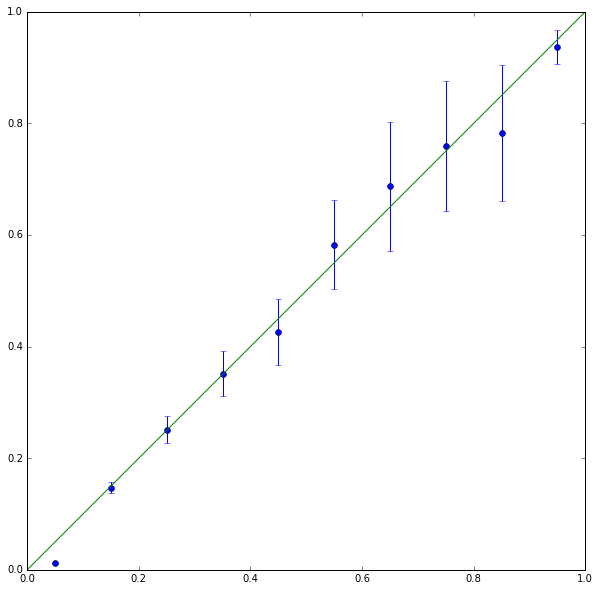

In [53]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111)

prob = bins + (1 / nbin / 2)  
ax1.errorbar(prob, tpr, yerr = err, fmt='o')
ax1.plot([0, 1], [0, 1])
#ax1.set_ylim(0, 1.02)
plt.show()

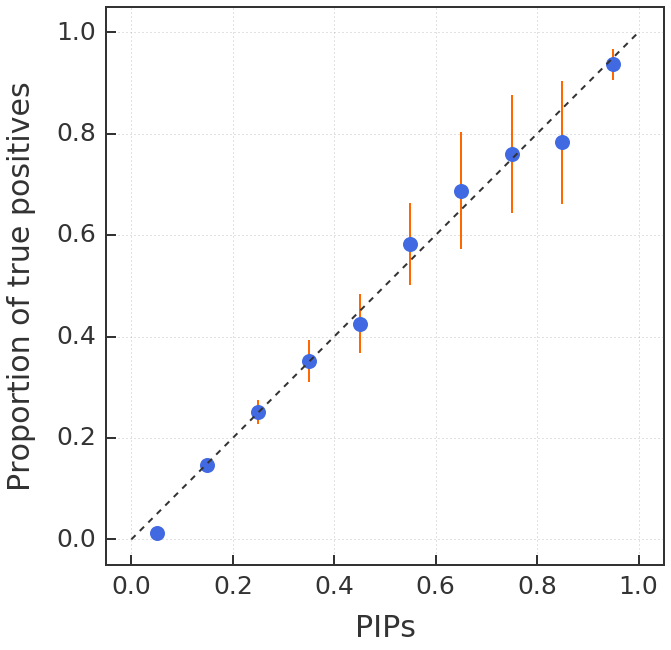

In [54]:
import matplotlib.pyplot as plt

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray

    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

colors = kelly_colors_hex
marker_list = ['8', '>', 'd', '<', '*', 'p', '^', 's', 'h', 'v', 'D', r'$\clubsuit$']

bordercolor = '#333333'
borderwidth = 2
figsize = (12,12)
axis_font_size = 30
label_font_size = 25
legend_font_size = 25

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111)

ax1.errorbar(prob, tpr, yerr = err, fmt='o',
             markersize = 15, markerfacecolor = 'royalblue',
             markeredgewidth = 0, #borderwidth, # controls thickness of the error bar cap
             markeredgecolor = 'royalblue',
             ecolor = colors[2], elinewidth = borderwidth, capsize = 10)
ax1.plot([0, 1], [0, 1], color = bordercolor, linestyle = 'dashed', linewidth = borderwidth)


mxlabel = 'PIPs'
mylabel = 'Proportion of true positives'

ax1.set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 15)
ax1.set_ylabel(mylabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 20)
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlim(-0.05, 1.05)
ax1.tick_params(axis='both', which = 'major',
               length = 10, width = borderwidth, pad=10,
               labelsize = label_font_size,
               color = bordercolor,
               labelcolor = bordercolor,
               bottom = True, top = False, left = True, right = False
              )
for side, border in ax1.spines.items():
    border.set_linewidth(borderwidth)
    border.set_color(bordercolor)
ax1.grid(color='dimgray', lw=0.5, alpha=0.8)
#yticklabels = ax1.get_yticks().tolist()
#ytl = [int(x / nsim) for x in yticklabels]
#ax1.set_yticklabels(ytl)
#ax1.set_xticks(np.arange(80, 220, 40))
#ax1.set_yticks(np.arange(0,18,4))
plt.savefig (calib_outfile, bbox_inches='tight')
plt.show()